## Spectrograph HP8566

Let's imitate the style of the following spectrograph

![Image Description](Example_Images/HP8566_Screencap_1.jpg)
![Image Description](Example_Images/HP8566_Screencap_2.jpg)
![Image Description](Example_Images/HP8566_Screencap_3.jpg)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap, Normalize
from scipy.interpolate import interp1d
from scipy.interpolate import CubicSpline
import cv2
from PIL import Image, ImageFilter

In [2]:

def plot_as_vectorscope (x, y, blurr=False, save_plot=False, Num_vertical_lines = 10, Num_horizontal_lines = 10, vector_lines_color = 0.82,
                         RGB_brightest_trace = (0.8, 1, 0.8), RGB_darkest_trace = (0, 0.2, 0), backgroung_color = '#000800', grid_opacity = 0.7,
                         graph_opacity = 0.5, grid_linewidth = 1, graph_linewidth = 1, Num_sample_points = 4, Gaussian_profile_segments = 10,
                         interpo_pts_per_data_pts = 3):
    '''
    ###################################### Thery of Operation #########################################
    # This cell in essence approximates the images above, vector graphics where an electron beam is steered into a 
    # green phosphorous screen shinning a dot into it, the faster this dot sweeps between data points the 
    # less intensity is transmitted into the phosphor and thus the dimmer the line gets. 
    # 
    # To replicate this we first generate some placeholder data, then we scan through the data N points at a time,
    # sampling our data into much smaller chuncks, these chunks can now be fitted to polynomials which is a way to
    # simulate how the beam will steer through the data points, the whole acquisition + beam steering chain has a 
    # bandwidth and thus drawing perfect lines between the points is impossible, an infinite bandwidth would be 
    # needed to change directions instantaneusly, thay's why we use a polinomial to change directions in a smooth
    # manner. 
    # 
    # We now have a way to simulate the beam path along our data points and now we need to calculate the speed, 
    # we compute the gradient for each point and compute a sort of normalized inverse function for it, this way
    # it is conditioned for the final step. We plot one line between each pair of interpolated points, this line
    # will have a brightness, width and opacity that is inversely proportional to it's speed (gradient).
    # 
    # We repeat these steps for every chunck in our dataset and we plot the whole graph. Lastly we do some aesthetic
    # changes to display some text, gridlines and background color that is reminiscent of the screen pictured above.
    # 
    ######################################### Parameters #########################################
    #  Visual parameters
    #
    #  These parameters only affect visual elements in the graph
    #
    #  @param x                          (array) 
    #  @param y                          (array) 
    #  @param blurr                      (bool) 
    #  @param save_plot                  (bool) 
    #  @param Num_vertical_lines         (int) Number of vertical lines for the grid in the graph.
    #  @param Num_horizontal_lines       (int) Number of horizontal lines for the grid in the graph.
    #  @param vector_lines_color         (float) Color for the grid lines and text in the graph (grayscale intensity from 0 to 1).
    #  @param RGB_brightest_trace        (tuple) RGB tuple for the brightest green shade in the gradient of the graph line.
    #  @param RGB_darkest_trace          (tuple) RGB tuple for the darkest green shade in the gradient of the graph line.
    #  @param background_color           (str) Hex code or RGB tuple for the background color of the graph.
    #  @param grid_opacity               (float) Opacity of the grid lines and text (value between 0 and 1, where 1 is fully opaque).
    #  @param graph_opacity              (float) Opacity of the graph line (value between 0 and 1, where 1 is fully opaque).
    #  @param grid_linewidth             (int) Thickness of the grid lines.
    #  @param graph_linewidth            (int) Thickness of the graph lines.
    #
    #  Performance parameters
    #
    #  These parameters control the accuracy and performance of the ray simulation, which is inversely proportional to computation time.
    #
    #  @param Num_sample_points          (int) Number of data points sampled in each loop for polynomial fitting.
    #  @param poly_degree                (int) Degree of the polynomial used for fitting the sampled points (typically one degree higher than the number of sample points).
    #  @param Gaussian_profile_segments  (int) Number of segments used to approximate a Gaussian profile along the ray.
    #  @param interpo_pts_per_data_pts   (int) Number of interpolated points generated between the sample points to achieve smoother curves.
    '''

    poly_degree = Num_sample_points + 1     # This polynome will need to be one order higher than the number 
    # Set up the figure with a black background and white grid lines
    fig, ax = plt.subplots(figsize=(12, 12), facecolor=backgroung_color)


    #################################### Beam Path 'Simulation' ####################################

    # Create a colormap with a more pronounced gradient (dark green to bright green) the color for each segment in the
    # graph will be taken from here
    green_cmap = LinearSegmentedColormap.from_list('custom_gradient', [RGB_darkest_trace, RGB_brightest_trace])  # Dark green to light green

    # Walk though data splitting into chuncks of length Num_sample_points

    # Fit a cubic spline to the noisy data
    cubic_spline = CubicSpline(x, y)

    # Generate a high-resolution set of x-values for plotting the smooth curve
    x_interpolated = np.linspace(x.min(), x.max(), len(x)*interpo_pts_per_data_pts)
    y_interpolated = cubic_spline(x_interpolated)

    # Electron beam speed is the gradient (used to determine brightness/green intensity)
    dydx = abs(np.gradient(y_interpolated, x_interpolated))

    # Normalize the derivative values for color mapping
    norm = Normalize(vmin=np.min(dydx), vmax=np.max(dydx))
    z = 1 - norm(dydx)  # Invert so that higher speeds generate darker greens

    # We are ready to plot our data but we need to first plot the grid lines so that they
    # don't overlap out graph



    ############################################ Grid ############################################

    # Make a fake hacky grid line because I can't get ax.grid to do what I want.
    max_x = x_interpolated.max()
    min_x = x_interpolated.min()
    max_y = y_interpolated.max()
    min_y = y_interpolated.min()
    x_ticks_spacing = ( max_x - min_x ) / Num_vertical_lines
    y_ticks_spacing = ( max_y - min_y ) / Num_horizontal_lines


    if (blurr):
        for index in range(0, Num_vertical_lines+1):
            # Create a vertical line defined by 2 points at the intended horizontal position that goes from minimum graph to max graph height
            x_points = [min_x + index * x_ticks_spacing, min_x + index * x_ticks_spacing]
            y_points = [min_y, max_y]
            for subindex in range(1, 10):
                ax.plot(x_points, y_points, linestyle='-',
                        color = green_cmap(vector_lines_color / subindex),
                        linewidth = grid_linewidth * subindex, 
                        alpha = grid_opacity * vector_lines_color /subindex )
            
        for index in range(0, Num_horizontal_lines+1):
            # Create a vertical line defined by 2 points at the intended horizontal position that goes from minimum graph to max graph height
            x_points = [min_x, max_x]
            y_points = [min_y + index * y_ticks_spacing, min_y + index * y_ticks_spacing]

            for subindex in range(1, 10):   
                ax.plot(x_points, y_points, linestyle='-',
                        color = green_cmap(vector_lines_color / subindex),
                        linewidth = grid_linewidth * subindex, 
                        alpha = grid_opacity / subindex )


    else:
        for index in range(0, Num_vertical_lines+1):
            # Create a vertical line defined by 2 points at the intended horizontal position that goes from minimum graph to max graph height
            x_points = [min_x + index * x_ticks_spacing, min_x + index * x_ticks_spacing]
            y_points = [min_y, max_y]

            ax.plot(x_points, y_points, linestyle='-',
                    color = green_cmap(vector_lines_color),
                    linewidth = graph_linewidth, 
                    alpha = grid_opacity * vector_lines_color )
        
        for index in range(0, Num_horizontal_lines+1):
            # Create a vertical line defined by 2 points at the intended horizontal position that goes from minimum graph to max graph height
            x_points = [min_x, max_x]
            y_points = [min_y + index * y_ticks_spacing, min_y + index * y_ticks_spacing]

            ax.plot(x_points, y_points, linestyle='-',
                    color = green_cmap(vector_lines_color),
                    linewidth = graph_linewidth, 
                    alpha = grid_opacity)



    # Customize the plot to simulate an oscilloscope look
    ax.set_facecolor(backgroung_color)  # Black background

    # Remove axis ticks and labels for a cleaner look
    ax.set_xticklabels([])
    ax.set_yticklabels([])

    # Now we can plot our data
    # Plot each interpolated segment with varying color based on speed
    if (blurr):
        for index in range(0, len(x_interpolated)-1):
            for subindex in range(1, Gaussian_profile_segments):
                ax.plot([x_interpolated[index], x_interpolated[index+1]], 
                        [y_interpolated[index], y_interpolated[index+1]], 
                        color = green_cmap(z[index]),
                        linewidth = graph_linewidth * z[index] * (subindex ** 1), 
                        alpha = graph_opacity * z[index] / subindex )

    else:
        for index in range(0, len(x_interpolated)-1):
            ax.plot([x_interpolated[index], x_interpolated[index+1]], 
                    [y_interpolated[index], y_interpolated[index+1]], 
                    color = green_cmap(z[index]),
                    linewidth = graph_linewidth * z[index], 
                    alpha = graph_opacity * z[index])




    ############################################ Text ############################################

    # Graphed text parameters
    font = 'monospace'
    plt.rcParams['font.size'] = 8  # Set default font size for all text
    plt.rcParams['font.weight'] = 'bold'  # Set default font weight (normal, bold, etc.)
    plt.rcParams['font.style'] = 'normal'  # Set default font style (normal, italic, oblique)
    #plt.rcParams['text.color'] = ''  # Set default font color
    plt.rcParams['text.usetex'] = False  # Disable LaTeX processing
    plt.rcParams['font.family'] = font  # Set to desired font

    # Add text to simulate an oscilloscope display (adjust positions as needed)
    top_height = max_y*1.01
    lower_height = min_y*1.3
    line_height = 0.1

    # Draw some text that is reminiscent of the HP8566 interface

    plt.text(0, top_height, "0.0dBm", color=green_cmap(vector_lines_color), alpha=graph_opacity)
    plt.text(-0.6, top_height, "REF", color=green_cmap(vector_lines_color), alpha=graph_opacity)
    plt.text(1.2, top_height, "ATTEN 10 dB", color=green_cmap(vector_lines_color), alpha=graph_opacity)

    plt.text(-0.6, lower_height, "START", color=green_cmap(vector_lines_color), alpha=graph_opacity)
    plt.text(0.2, lower_height, "0 Hz", color=green_cmap(vector_lines_color), alpha=graph_opacity)
    plt.text(8.0, lower_height, "RBW 1 MHz", color=green_cmap(vector_lines_color), alpha=graph_opacity)

    plt.savefig('Python_Output/original.png')

    # Display the plot
    plt.show()



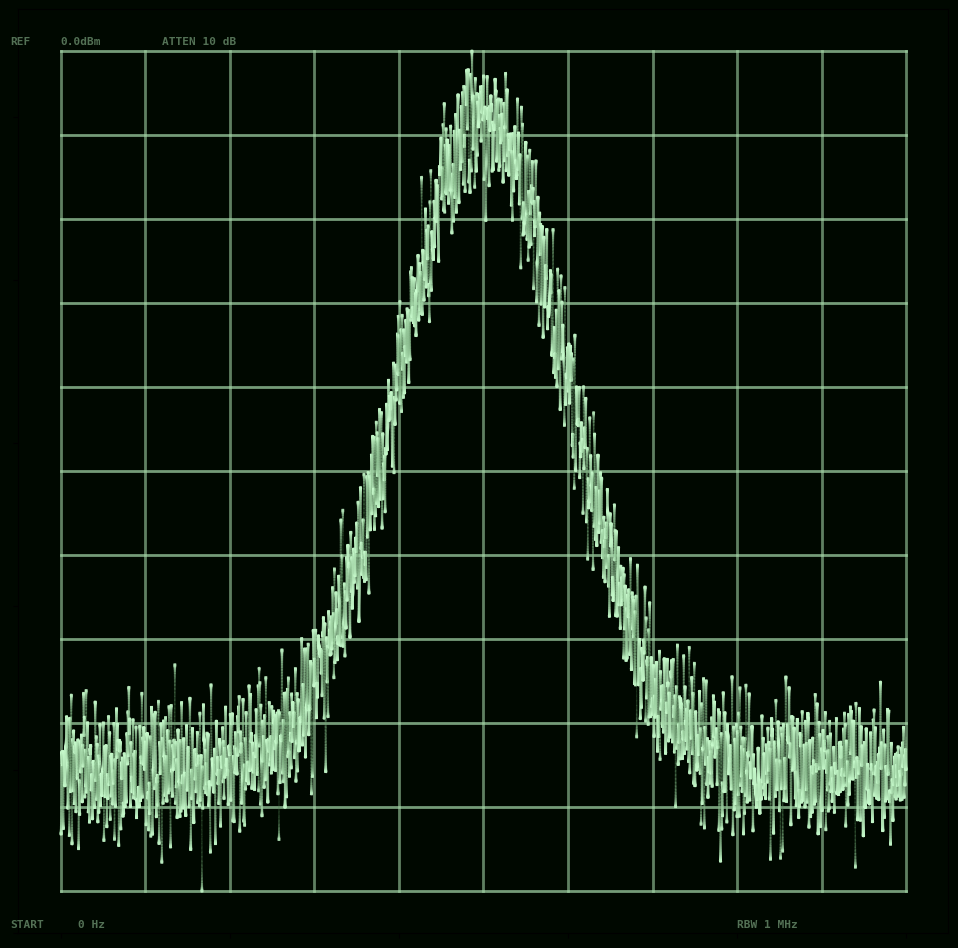

In [3]:
# Generate some example data

# Gaussian function: mean = 0, standard deviation = 1
Num_data_points = 2000
x = np.linspace(0, 10, Num_data_points)
mu = 0  # Mean
sigma = 1  # Standard deviation
gaussian = (1 / (sigma * np.sqrt(2 * np.pi))) * np.exp(-(x - 5 - mu)**2 / (2 * sigma**2))

# Add some random noise to the Gaussian
noise = np.random.normal(0, 0.02, x.shape)  # Noise with mean 0 and small standard deviation
y = noise + gaussian
plot_as_vectorscope (x, y, blurr=False, save_plot=True, 
                     RGB_brightest_trace = (0.8, 1, 0.82), RGB_darkest_trace = (0, 0.2, 0), 
                     interpo_pts_per_data_pts = 30,
                     grid_linewidth = 2, graph_linewidth = 2)